# Gaussian Process Regression


**Gaussian Process Regression (GPR)** is a non-parametric approach to describe the relationships between variables without specifying the underlying distribution. By choosing Gaussian distributions to model the data, you benefit from their properties, for example that the marginal and conditional distributions are also Gaussian [1]. 


## Gaussian Process

A **Gaussian Process (GP)** is a generalization of a multivariate Gaussian distribution to *infinite dimension* and used to describe a distribution over functions. It defines a prior distribution over functions from which a posterior distribution can be inferred when data is observed.
A GP is completely specified by a mean function $m(x)$ and a covariance function $k(x,x')$ of a real process $f(x)$:    

$$f(x) \sim GP(m(x),k(x,x')).$$     
Usually, the mean value is set to $m(x)=0$ since the GP is flexible enough to model the mean arbitrarily well.
The function values $f(x_1),...,f(x_n)$ are jointly Gaussian, corresponding to any number of input points $n$ [1,2,3]. 


## Kernels

**Kernels** are used as *similarity measure* between objects and define the covariance matrix $\Sigma$. A kernel $k$ is a positive definite kernel function and describes the shape of the distribution as well as characteristics of the function we want to predict. If two points $x$ and $x'$ are deemed by the kernel to be similar, then we expect the output of the function at those points to be similar, too. The kernel function $k$ is a real-valued function of two arguments, $k(x,x') \in \mathbb{R}$. To retrieve the covariance matrix $\Sigma$, we evaluate $k$ on each pairwise combination of the set of points, $k: \mathbb{R}^n \times \mathbb{R}^n \rightarrow \mathbb{R},~ \Sigma = Cov(X,X') = k(x,x')$.  
The most common kernel functions are the following [2,4]:  

* Radial Basis Function (RBF): $k(x,x')= \sigma^2 exp(- \frac{||x-x'||^2}{2\ell^2}) $  
The RBF kernel is a stationary kernel, hence it is invariant to translations and the covariance between two points depends only on their relative positions. Scale factor $\sigma^2$ is the variance controlling vertical variation, and describing the average distance of the function away from its mean. Parameter $\ell$ determines the horizontal lengthscale ober which the function varies, and determines the reach of influence on the neighbors. 


* Linear: $k(x,x') = \sigma_b^2 + \sigma^2(x-c)(x'-c)$  
The linear kernel is a non-stationary kernel, so the covariance between two points depends on their absolute positions. Parameter $c$ determines the point on which all posterior functions hinge. The constant variance $\sigma_b$ describes how far from 0 the height of the function will be at zero, hence adding an uncertain offset to the model.


* Periodic: $k_{per}(x,x') = \sigma^2 \exp ( - \frac{2 \sin^2 (\pi || x - x' || / p) }{\ell^2} ) $  
The periodic kernel is a stationary kernel like the RBF kernel, but contains an additional parameter $p$ that controls the periodicity of the function.



## Prior

We define the **prior** as a GP over the test set $X_*$, where each test point is treated as a random variable. In our example, we choose $|X_*|=N=200$ linearly-spaced values from 0 to 250 as test set to get the prior $P_{X_*}$ before any data is observed. The prior has dimensionality $N$ and revolves around $\mu=0$. The covariance matrix $\Sigma_{**}$ is computed by applying the kernel function $k$ to the test points $X_*$, $\Sigma_{**} = k(X_*,X_*)$. 
To demonstrate realizations of a GP we implement the prior distribution as previously described with following hyperparameters:  
* RBF: $\sigma^2 = 3,~ \ell = 15$  
* Linear: $\sigma^2 = 3,~ \sigma_b^2 = 2,~ c = 0.5$  
* Periodic: $\sigma^2 = 3,~ \ell = 15,~ p = 25$

and generate a random Gaussian vector $f_* \sim \mathcal{N}(\mu, k(X_*,X_*)) = \mathcal{N}(0,\Sigma_{**})$ to sample five functions from each Prior.

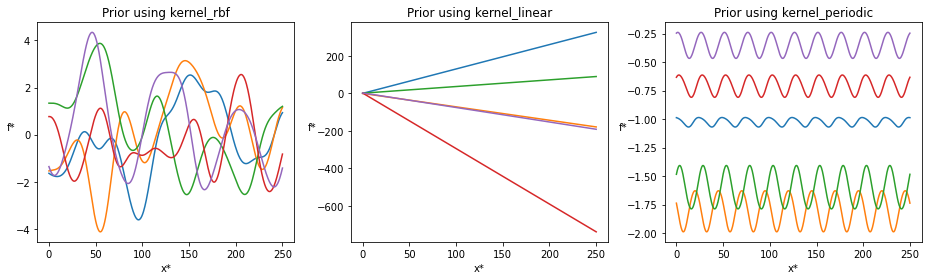

In [88]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from collections import defaultdict



def kernel_rbf(x, y, param):
    """ Radial Basis Function Kernel 
    
    Args:
    x : First input vector of kernel (N,1)
    y : Second input vector of kernel (N,1)
    param : dictionary
            Contains scale factor variance, and lengthscale ell
        
    Returns:
        Covariance matrix of each pairwise combination of set of points
    """
    variance = param['var']
    lengthscale = param['ell']
    # Euclidean distance between points
    eucdist = np.sum(x**2,1).reshape(-1,1) + np.sum(y**2,1) - 2*np.dot(x, y.T)
    return variance * np.exp(-0.5 * eucdist * 1/(lengthscale**2))
    
    
def kernel_linear(x, y, param):
    """ Linear Kernel
    """
    variance = param['var']
    variance_b = param['var_b']
    offset = param['off']
    return variance_b + variance * np.dot((x-offset), (y-offset).T)


def kernel_periodic(x, y, param):
    """ Periodic Kernel
    """
    variance = param['var']
    lengthscale = param['ell']
    period = param['per']
    return variance * np.exp(-(2*np.sin((np.pi * (x - y.T))/period)**2)/ (lengthscale**2))



# define all hyperparameters for all kernels
params = {'var': 3,
          'ell': 15,        # larger l -> less wiggles
          'var_b': 2,
          'off': 0.5,
          'per': 25}


# Test Data: N points from 0 to 15
N_s = 500
X_s = np.linspace(0, 250, N_s).reshape(-1,1)


# Priors using RBF and linear kernel
plt.figure(figsize=(13, 4))

for i, kernel in enumerate([kernel_rbf, kernel_linear, kernel_periodic]):
    # compute mean and covariance
    mu_prior = np.zeros(X_s.shape)
    cov_prior = kernel(X_s, X_s, params)
    # sample 5 normals from GP prior and plot
    f_prior = np.random.multivariate_normal(mu_prior.ravel(), cov_prior, 5)
    plt.subplot(1, 3, (i+1))
    for sample in f_prior:
        plt.plot(X_s, sample, lw=1.5, ls='-')
        plt.title(f'Prior using {kernel.__name__}')
        plt.xlabel('x*')
        plt.ylabel('f*', rotation=0)
plt.tight_layout()        
plt.show()



## Combination of kernels

It is possible to combine two (or more) kernels, what is especially useful when they are defined on different inputs to the function, or if we want to have more high-level structures in the model. A standard way is to **multiply** two kernels, then the resulting kernel will have high value only if both of the base kernels have a high value. You can think of it as an *AND* operation. In contrast, **adding** two kernels can be thought of as an *OR* operation. That means that the resulting kernel will have high value if either of the two base kernels have a high value [4].

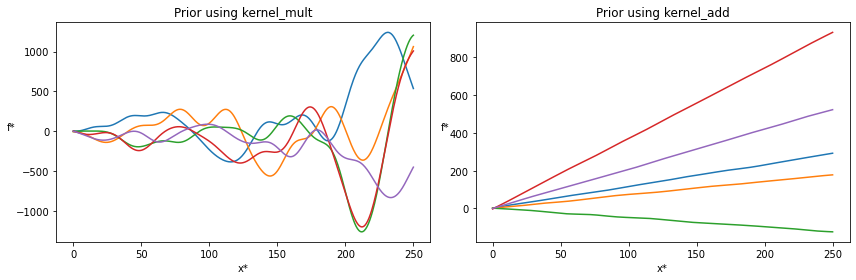

In [89]:
def kernel_mult(x, y, param):
    """ Multiply RBF and Linear Kernel
    """
    return kernel_rbf(x, y, param) * kernel_linear(x, y, param)

def kernel_add(x, y, param):
    """ Add RBF and Linear Kernel
    """
    return kernel_rbf(x, y, param) + kernel_linear(x, y, param)


# Priors using combinations of kernels
plt.figure(figsize=(12, 4))
for i, kernel in enumerate([kernel_mult, kernel_add]):
    # compute mean and covariance
    mu_prior = np.zeros(X_s.shape)
    cov_prior = kernel(X_s, X_s, params)
    # sample 5 normals from GP prior and plot
    f_prior = np.random.multivariate_normal(mu_prior.ravel(), cov_prior, 5)
    plt.subplot(1, 2, (i+1))
    for sample in f_prior:
        plt.plot(X_s, sample, lw=1.5, ls='-')
        plt.title(f'Prior using {kernel.__name__}')
        plt.xlabel('x*')
        plt.ylabel('f*', rotation=0)
plt.tight_layout()        
plt.show()


## Observations  



Now we want to incorporate knowledge from collected **training data**. First, we assume that we obtained perfect measurements and have *noise-free* observations. We get the training set $\{(x_i,f_i)|i=1,...,n\}$, consisting of inputs $X$ and function outputs $f$. 


We test the method on the popular **SIR model** used to study the spread of an epidemics. It models the dynamics of **S**usceptible, **I**nfected, and **R**ecovered individuals for a fixed population size $n$ [9]. We use a simple representation of the SIR model as a CTMC that includes stochasticity. Here, only two reactions (events) are considered [10]:  
- infection: S + I $\xrightarrow{k_i}$ 2 I  
- recovery:  I $\xrightarrow{k_r}$ R  


Our goal is to show the applicability of GPR on a simple example for predicting a collective response. Therefore, we fix the two rates, $k_i = 0.001$ and $k_r = 0.1$, and the initial number of infections, $I_0 = 5$, and want to infer the final number of infections for different population sizes. 


In the following shell, we invoke the model-checking tool *PRISM* to run the SIR model for different population sizes $n = X = [25, 50, 75, 100, 125, 150, 175, 200]$. As a result, *PRISM* saves the number of susceptible, infected and recovered individuals after $t=120$ seconds. This means, for our training inputs $X=n$ we get the simulated outputs $f=R[120]$ (final number of recovered people, since in this simple model this is equal to the number of infections during the epidemics).


In [42]:
# number of simulated paths for each population size
num_paths = 100
# population sizes for training data
pop_sizes = np.arange(25, 225, 25) 

# simulate chain with Prism and save paths
for p in pop_sizes:
    for i in range(0, num_paths):
        result = "/Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_" + str(p) + "_path_" + str(i) + ".txt"
        resultfile = open(result ,"w")
        resultfile.close()
        resultfile = open(result, "r+")
        prismcommand = "/Applications/prism-4.7-src/prism/bin/prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=" + str(p) + " -simpath changes=true,time=120 " + result + " -simpathlen 10000"
        prismprocess = subprocess.check_call(prismcommand, stdin=None, stdout=None , stderr=None, shell=True)
        resultfile.close()

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:17 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=25 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_0.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 125 steps, total time 120.3991411283518 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_0.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:17 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=25 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThe


PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:19 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=25 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_12.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 103 steps, total time 122.48385079065416 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_12.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:19 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=25 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Maste


Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 86 steps, total time 120.77354486342855 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_24.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:21 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=25 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_25.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 104 steps, total time 120.09216095705425 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_25.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 3


Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 77 steps, total time 120.81727299269556 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_36.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:23 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=25 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_37.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 95 steps, total time 122.62351458622834 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_37.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31


Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 111 steps, total time 120.99612362065143 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_48.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:25 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=25 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_49.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 66 steps, total time 120.09962815836951 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_49.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 3


Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 118 steps, total time 122.16804022190878 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_60.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:27 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=25 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_61.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 77 steps, total time 120.65745718084487 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_61.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 3


Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 105 steps, total time 121.29509865361779 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_73.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:29 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=25 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_74.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 73 steps, total time 121.81552519473857 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_74.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 3


Generating random path with time limit 120.0...

Generated path: 104 steps, total time 120.31366995224333 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_85.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:31 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=25 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_86.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 134 steps, total time 120.04058281797128 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_86.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:31 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory lim


Generating random path with time limit 120.0...

Generated path: 113 steps, total time 120.7670757781783 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_97.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:33 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=25 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_98.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 96 steps, total time 120.82345365589079 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_25_path_98.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:33 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limit


Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 65 steps, total time 121.21214403069428 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_50_path_9.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:35 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=50 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_50_path_10.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 67 steps, total time 120.35942737753302 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_50_path_10.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 


PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:37 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=50 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_50_path_22.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 110 steps, total time 120.01180255196165 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_50_path_22.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:37 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=50 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Maste


PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:39 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=50 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_50_path_34.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 109 steps, total time 121.68587211290807 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_50_path_34.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:40 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=50 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Maste


PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:42 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=50 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_50_path_47.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 81 steps, total time 120.11976292040147 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_50_path_47.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:42 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=50 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Master


Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 94 steps, total time 120.24079160907047 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_50_path_59.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:44 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=50 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_50_path_60.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 110 steps, total time 123.09028149541686 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_50_path_60.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 3

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:47 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=50 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_50_path_72.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 118 steps, total time 122.10682584749668 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_50_path_72.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:47 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=50 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Master

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:49 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=50 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_50_path_85.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 102 steps, total time 120.19194901124051 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_50_path_85.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:49 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=50 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Master

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:51 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=50 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_50_path_97.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 103 steps, total time 120.0345815650983 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_50_path_97.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:51 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=50 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterT

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:53 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=75 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_75_path_9.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 105 steps, total time 125.19424504922729 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_75_path_9.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:53 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=75 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterTh


Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 104 steps, total time 120.40217412959667 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_75_path_21.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:55 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=75 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_75_path_22.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 111 steps, total time 120.57544657632184 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_75_path_22.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 


Generating random path with time limit 120.0...

Generated path: 123 steps, total time 125.6187001423797 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_75_path_34.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:57 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=75 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_75_path_35.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 121 steps, total time 120.19341632617407 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_75_path_35.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:57 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limi


Generating random path with time limit 120.0...

Generated path: 112 steps, total time 120.27047360828026 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_75_path_47.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:17:59 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=75 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_75_path_48.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 91 steps, total time 120.35261015522457 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_75_path_48.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:00 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limi


PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:02 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=75 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_75_path_60.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 93 steps, total time 120.22099247408389 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_75_path_60.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:02 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=75 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Master

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:04 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=75 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_75_path_72.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 95 steps, total time 121.61194067509763 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_75_path_72.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:04 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=75 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterT

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:06 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=75 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_75_path_85.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 75 steps, total time 120.55947406948663 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_75_path_85.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:06 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=75 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterT

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:08 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=75 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_75_path_98.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 119 steps, total time 122.10819846971343 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_75_path_98.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:08 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=75 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Master


Generated path: 114 steps, total time 124.6417865928901 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_100_path_10.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:10 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=100 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_100_path_11.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 140 steps, total time 120.05405220119788 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_100_path_11.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:10 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: pris


Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 75 steps, total time 120.46521094690429 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_100_path_23.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:12 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=100 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_100_path_24.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 90 steps, total time 121.78609763758841 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_100_path_24.txt)

PRISM
=====

Version: 4.7
Date: Mon Ja

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:14 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=100 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_100_path_36.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 100 steps, total time 120.45487639461831 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_100_path_36.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:15 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=100 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Ma


PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:17 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=100 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_100_path_49.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 86 steps, total time 120.03563746756072 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_100_path_49.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:17 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=100 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Ma

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:19 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=100 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_100_path_62.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 103 steps, total time 120.28517892444094 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_100_path_62.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:19 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=100 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Ma

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:21 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=100 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_100_path_75.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 101 steps, total time 122.19715543610775 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_100_path_75.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:21 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=100 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Ma

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:23 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=100 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_100_path_87.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 122 steps, total time 121.49242640847943 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_100_path_87.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:23 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=100 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Ma

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:25 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=125 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_125_path_0.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 100 steps, total time 120.16160287176295 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_125_path_0.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:25 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=125 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Mast


Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 146 steps, total time 121.6126718784809 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_125_path_12.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:28 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=125 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_125_path_13.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 126 steps, total time 120.33665672076594 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_125_path_13.txt)

PRISM
=====

Version: 4.7
Date: Mon J


PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:30 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=125 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_125_path_25.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 135 steps, total time 120.51934527472233 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_125_path_25.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:30 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=125 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/M

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:32 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=125 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_125_path_38.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 111 steps, total time 120.27781121660061 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_125_path_38.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:32 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=125 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Ma

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:34 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=125 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_125_path_50.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 148 steps, total time 120.98668549036081 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_125_path_50.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:34 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=125 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Ma

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:36 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=125 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_125_path_62.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 76 steps, total time 120.74211770298339 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_125_path_62.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:36 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=125 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Mas


Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 147 steps, total time 120.99234491322554 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_125_path_74.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:38 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=125 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_125_path_75.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 126 steps, total time 120.28313494523645 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_125_path_75.txt)

PRISM
=====

Version: 4.7
Date: Mon 


Generating random path with time limit 120.0...

Generated path: 86 steps, total time 121.18873369491712 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_125_path_87.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:40 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=125 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_125_path_88.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 123 steps, total time 120.4279385343561 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_125_path_88.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:41 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory l


Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 158 steps, total time 120.58541194498768 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_0.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:43 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=150 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_1.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 120 steps, total time 120.1290958073534 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_1.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:45 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=150 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_13.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 193 steps, total time 120.1406322125278 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_13.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:45 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=150 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Mas

Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=150 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_25.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 88 steps, total time 121.36039001372033 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_25.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:47 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=150 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_26.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:49 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=150 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_37.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 195 steps, total time 121.36498839068182 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_37.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:49 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=150 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Ma

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:51 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=150 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_49.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 159 steps, total time 120.55757351646653 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_49.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:51 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=150 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Ma


Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 163 steps, total time 123.58890713788568 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_61.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:53 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=150 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_62.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 165 steps, total time 121.12982133038349 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_62.txt)

PRISM
=====

Version: 4.7
Date: Mon 


Generating random path with time limit 120.0...

Generated path: 74 steps, total time 120.28941453487516 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_74.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:55 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=150 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_75.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 239 steps, total time 120.26285177737051 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_75.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:55 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory 

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:57 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=150 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_87.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 112 steps, total time 120.73757679515246 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_87.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:57 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=150 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Ma


PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:59 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=150 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_99.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 138 steps, total time 120.06860071940675 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_150_path_99.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:18:59 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=175 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/M


Generated path: 189 steps, total time 120.43216696513046 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_175_path_11.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:02 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=175 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_175_path_12.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 240 steps, total time 120.89832854009993 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_175_path_12.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:02 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: pri


Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 264 steps, total time 121.28941539454704 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_175_path_24.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:04 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=175 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_175_path_25.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 285 steps, total time 122.66887829122632 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_175_path_25.txt)

PRISM
=====

Version: 4.7
Date: Mon 


Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 266 steps, total time 122.78043031498437 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_175_path_36.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:06 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=175 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_175_path_37.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 190 steps, total time 122.32037523346904 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_175_path_37.txt)

PRISM
=====

Version: 4.7
Date: Mon 


PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:08 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=175 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_175_path_49.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 235 steps, total time 127.3489263787847 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_175_path_49.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:08 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=175 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Ma

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:10 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=175 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_175_path_61.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 258 steps, total time 120.64387684281647 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_175_path_61.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:10 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=175 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Ma


PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:12 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=175 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_175_path_74.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 131 steps, total time 120.33988689531432 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_175_path_74.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:12 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=175 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/M


PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:14 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=175 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_175_path_86.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 278 steps, total time 120.05652374778319 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_175_path_86.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:14 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=175 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/M


PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:16 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=175 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_175_path_98.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 193 steps, total time 121.08302708738512 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_175_path_98.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:16 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=175 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/M


Generated path: 338 steps, total time 120.00851669242336 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_200_path_9.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:18 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=200 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_200_path_10.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 347 steps, total time 121.58312033165593 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_200_path_10.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:19 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: pris


PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:20 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=200 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_200_path_22.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 350 steps, total time 120.23279578759131 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_200_path_22.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:21 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=200 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/M


PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:23 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=200 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_200_path_35.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 118 steps, total time 120.71850911867065 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_200_path_35.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:23 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=200 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/M


PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:25 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=200 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_200_path_47.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 356 steps, total time 121.82103580607142 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_200_path_47.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:25 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=200 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/M


PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:27 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=200 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_200_path_59.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 331 steps, total time 120.39096299717892 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_200_path_59.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:27 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=200 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/M


Generated path: 312 steps, total time 121.35859532573399 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_200_path_70.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:29 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=200 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_200_path_71.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 342 steps, total time 120.75780778419603 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_200_path_71.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:29 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: pri


PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:31 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=200 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_200_path_83.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 307 steps, total time 120.4822541469188 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_200_path_83.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:31 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=200 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/Ma


Generating random path with time limit 120.0...

Generated path: 337 steps, total time 123.13325743544581 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_200_path_94.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:33 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory limits: cudd=1g, java(heap)=1g
Command line: prism /Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm -const maxPop=200 -simpath 'changes=true,time=120' /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_200_path_95.txt -simpathlen 10000

Parsing model file "/Users/juliaklein/Documents/uni/MasterThesis/models/sir.pm"...

Type:        CTMC
Modules:     SIR 
Variables:   popS popI popR 

Generating random path with time limit 120.0...

Generated path: 355 steps, total time 123.02907102405321 (exported to /Users/juliaklein/Documents/uni/MasterThesis/data/sir/sir_200_path_95.txt)

PRISM
=====

Version: 4.7
Date: Mon Jan 31 11:19:33 CET 2022
Hostname: Julias-MacBook-Pro.local
Memory

For a population of size $n$, we have $n+1$ possible outcomes $o=(0,1,...,n) \in \mathbb{N}^{n+1}$ with the associated probabilities $p=(p_0,...,p_n) \in \mathbb{R}^{n+1}$. Below you can see the resulting histograms of recovered individuals for each of the 8 population sizes.  

Since it is difficult to process and predict a whole distribution, we start by computing the first statistical moment of the histogram, its mean value   

$$\overline{x} = \sum_i (p_io_i)$$

to predict the collective response of other population sizes.  

Therefore, our training data consists of inputs (population size) $X=[25,50,75,100,125,150,175,200]$ and outputs (mean values) $f=[6.03, 8.82, 13.35, 26.36, 41.95, 66.69, 111.4, 150.96]$, or mean proportions $[0.2412, 0.1764, 0.178, 0.2636, 0.3356, 0.4446, 0.6366, 0.7548]$.  

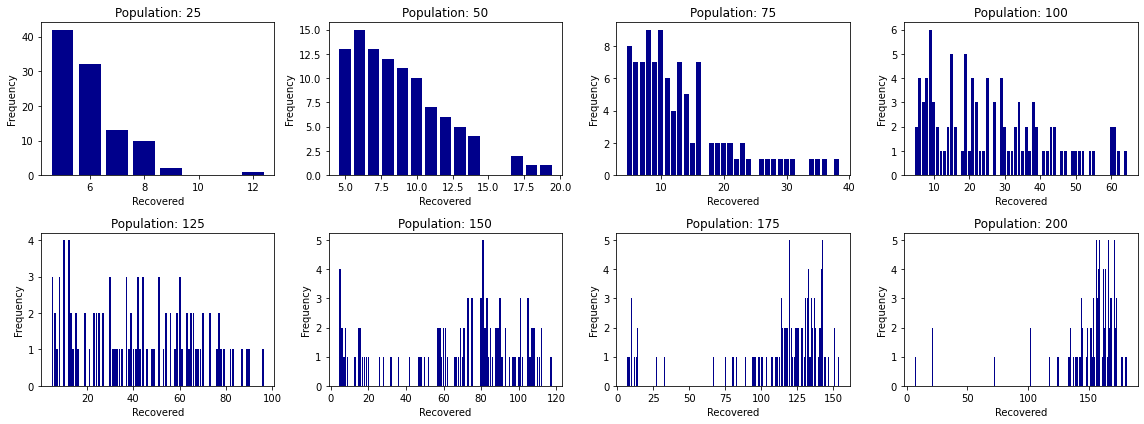

Mean values:  [6.03, 8.82, 13.35, 26.36, 41.95, 66.69, 111.4, 150.96]

--------------------------------------- Different representation ---------------------------------------


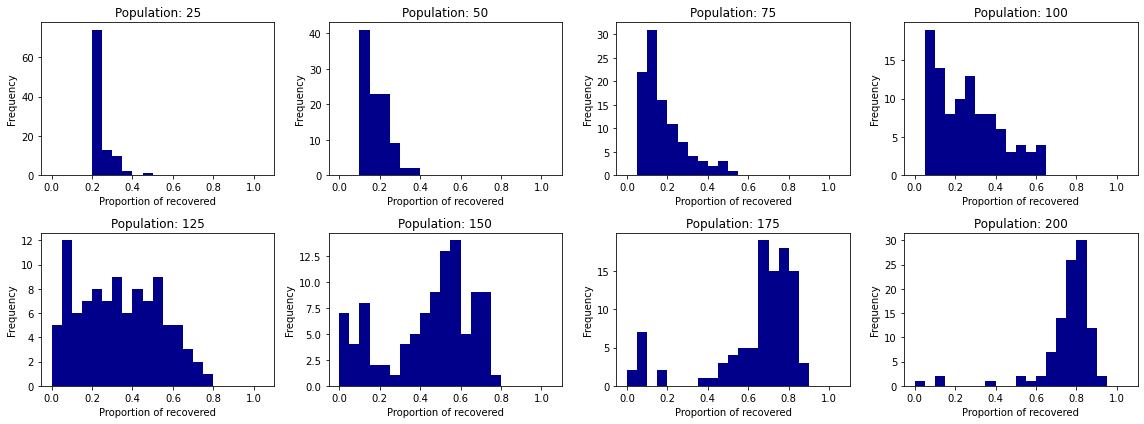

Mean proportions:  [0.2412, 0.1764, 0.178, 0.2636, 0.3356, 0.4446, 0.6366, 0.7548]


In [109]:
# save number of recovered people for each population size and experiment
recovered = defaultdict(list)

# read outcomes for all population sizes and compute number of satisfactions
for dirpath, dirs, files in os.walk("/Users/juliaklein/Documents/uni/MasterThesis/data/sir"):
    for file in files:
        p = int((file.split("_")[1]))
        with open(os.path.join(dirpath, file), 'r') as f:
            data = f.readline()
            for last_line in f:
                pass
            R = int(last_line.split(" ")[5])
            recovered[p].append(R)

means1 = []
means2 = []
# Plot histogram training data
plt.figure(figsize=(16, 6))
i=0
for key in sorted(recovered):
    a, counts = np.unique(recovered[key], return_counts = True)
    means1.append(np.sum(a*counts)/np.sum(counts))
    means2.append(np.sum((a/key)*counts)/np.sum(counts))
    plt.subplot(2,4,(i+1))
    plt.bar(a, counts, 0.8, color="darkblue")
    plt.xlabel('Recovered')
    plt.ylabel('Frequency')
    plt.title(f'Population: {key}')
    plt.tight_layout()
    i+=1
plt.show()

print('Mean values: ', means1)

print('\n--------------------------------------- Different representation ---------------------------------------')
    
plt.figure(figsize=(16, 6))
i=0
for key in sorted(recovered):
    rec = [r/key for r in recovered[key]]
    plt.subplot(2,4,(i+1))
    plt.hist(rec, bins=np.arange(0,1.1,0.05), color='darkblue')    
    plt.xlabel('Proportion of recovered')
    plt.ylabel('Frequency')
    plt.title(f'Population: {key}')
    plt.tight_layout()
    i+=1
plt.show()

print('Mean proportions: ', [round(m, 4) for m in means2])



## Derive Posterior Distribution

Given the test set $X_*$ and training data $\{X,~ f\}$, we want to predict the function outputs $f_*$. 


The *joint distribution* of training and test outputs is: $\begin{bmatrix} f \\ f_* \end{bmatrix} \sim \mathcal{N} \begin{pmatrix} \begin{bmatrix} \mu \\ \mu_* \end{bmatrix}, \begin{bmatrix} \Sigma & \Sigma_* \\ \Sigma_*^T & \Sigma_{**} \end{bmatrix} \end{pmatrix} $,  

where $\Sigma$ denotes the covariance matrix evaluated at all paris of training points $X$, $\Sigma_*$ at training and test points, and $\Sigma_{**}$ at test points $X_*$, and $\mu=\mu_*=0$.  

The **posterior distribution** $p(f_*|X_*,X,f)$ can be derived by *conditioning* the joint Gaussian prior distributions on the observations. We get:  

\begin{align}
f_*|X_*,X,f \sim \mathcal{N}(\Sigma_*^T \Sigma^{-1}f,~ \Sigma_{**} - \Sigma_*^T \Sigma^{-1} \Sigma_*) 
\label{eq:post}\tag{1}
\end{align}

The function values $f_*$ can be sampled from the joint posterior distribution by evaluating the mean and covariance matrix and generating samples. 


Hint, according to [2]: For reasons of numerical stability, it is unwise to directly invert $\Sigma$. More robust alternative: Cholesky decomposition, $\Sigma = LL^T$. Then, solve for $\alpha = \Sigma^{-1}f = L^{-T}L^{-1}f$. Compute mean using $\Sigma_*^T \alpha$ and variance using $\Sigma_{**} - \Sigma_*^T L^{-T} L^{-1} \Sigma_*$.





Here, we sample from the GP posterior after conditioning on the previously mentioned observations $f$. The shaded area represents the uncertainty as the $95\%$ confidence region (pointwise mean $\pm$ two times the standard deviation for each input value).  

Note that the variance is zero in a noise-free model, and that all functions go directly through the training points [2,5].

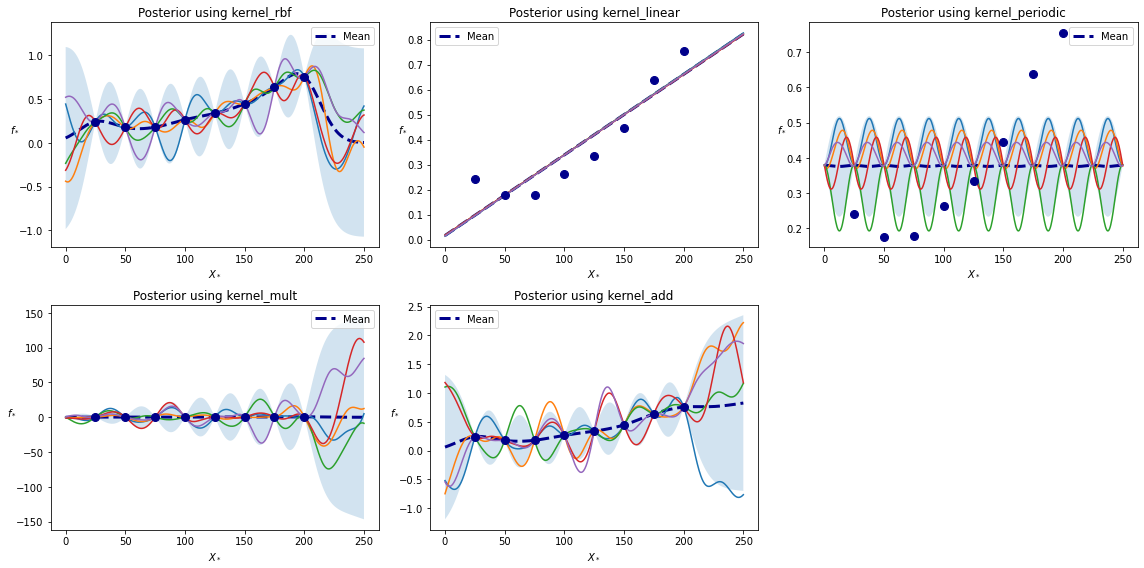

In [116]:
def posterior(X, X_s, f, kernel=kernel_rbf, params=params, noise=1e-15):
    """ Derive Posterior Distribution using Equation (1)
    
    Args:
        X: Training Data inputs (N,1) 
        X_s: Test Data inputs (Ns,1)
        f: Training Data outputs (N,1)
        kernel: Kernel function to compute covariance matrices, default RBF
        params: dictionary with hyperparameters for kernels
        noise: variance of noisy observations, default 1e-15 for numerical stability
        
    Returns:
        mu_s: Mean vector of posterior distribution (Ns,1)
        sigma_s: Covariance matrix of posterior distribution (Ns,Ns)
        
    """
    N, N_s = len(X), len(X_s)

    cov = kernel(X, X, params) + noise * np.eye(N)             
    cov_s = kernel(X, X_s, params)                             
    cov_ss = kernel(X_s, X_s, params)                          
    
    # Cholesky decomposition for numerically stable matrix inversion
    L = np.linalg.cholesky(cov + 1e-5 * np.eye(N))
    alpha_1 = np.linalg.solve(L, f)
    alpha = np.linalg.solve(L.T, alpha_1)
    mu_s = cov_s.T.dot(alpha)
    
    v = np.linalg.solve(L, cov_s)
    sigma_s = cov_ss - v.T.dot(v)
    
    # without Cholesky:
    #mu_s = cov_s.T.dot(np.linalg.inv(cov)).dot(f)
    #sigma_s = cov_ss - cov_s.T.dot(np.linalg.inv(cov)).dot(cov_s)
    
    return mu_s, sigma_s



def plot_gp(mu, cov, X_s, X=None, f=None, samples=[], ax0=plt, pred=7):
    """ Plot GP with mean function & uncertainty
    Adapted from: https://github.com/krasserm/bayesian-machine-learning/blob/dev/gaussian-processes/gaussian_processes_util.py
    
    Args:
        mu: Mean vector of (posterior) distribution (Ns,1)
        cov: Covariance matrix of posterior distribution (Ns,Ns)
        X_s: Test Data inputs (Ns,1)
        X: Training Data inputs (N,1)
        f: Training Data outputs (N,1)
        samples: Drawn samples from GP (5,Ns)
        ax0: Plot to draw GP on
        pred: Specifies a test point with its prediction, default 7
        
    """
    X_s = X_s.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
        
    ax0.fill_between(X_s, mu + uncertainty, mu - uncertainty, alpha=0.2)
    ax0.plot(X_s, mu, '--', color='darkblue', lw=3, label='Mean')
    for i, sample in enumerate(samples):
        ax0.plot(X_s, sample, lw=1.5)
    if X is not None:
        ax0.plot(X, f, 'o', ms=8, color='darkblue')
    ax0.legend()



# Noise free Training data
X = pop_sizes.reshape(-1,1)
N = len(X)
f = np.array(means2).reshape(-1,1)

# define all hyperparameters for all kernels
params = {'var': 0.3,
          'ell': 15,        
          'var_b': 1,
          'off': 0.5,
          'per': 25}

# Posterior using all kernels & combinations
plt.figure(figsize=(16, 8))

for i, kernel in enumerate([kernel_rbf, kernel_linear, kernel_periodic, kernel_mult, kernel_add]):
    # compute mean and covariance of the posterior distribution and draw 5 samples
    mu_post, cov_post = posterior(X, X_s, f, kernel, params)
    samples = np.random.multivariate_normal(mu_post.ravel(), cov_post, 5)
    idx_pred = np.absolute(X_s-7).argmin()
    plt.subplot(2,3,(i+1))
    plot_gp(mu_post, cov_post, X_s, X, f, samples)
    plt.xlabel('$X_*$')
    plt.ylabel('$f_*$', rotation=0)
    plt.title(f'Posterior using {kernel.__name__}')
    # compute prediction for x* = 7
#    \n f_*[7] = {mu_post[idx_pred]}')
plt.tight_layout()        
plt.show()

## Noisy Observations

Normally, we do not have perfect data, but some noise available due to measurement errors, for example. In this case, the training points are only approximated and the variance is not zero at those training points.   
If we assume that the observational noise is normally distributed, the posterior is still a GP and the inference analytically tractable. 
We assume $y = f(x) + \epsilon$ with $f \sim GP(0,\Sigma)$ and $\epsilon \sim \mathcal{N}(0, \sigma_f^2I)$. The noise variance $\sigma_f^2$ is an additional parameter of the likelihood and independently added to each observation. We get:  

$p(y|f) = \mathcal{N}(y|f,\sigma_f^2I).$  

We can then write the joint distribution of training and test values as  

$$ \begin{bmatrix} y \\ f_* \end{bmatrix} \sim \mathcal{N} \begin{pmatrix} 0, \begin{bmatrix} \Sigma_y & \Sigma_* \\ \Sigma_*^T & \Sigma_{**} \end{bmatrix} \end{pmatrix} $$

with $\Sigma_y := \Sigma + \sigma_f^2I$.

Again, we derive the conditional distribution and get  

$$ f_*|X_*,X,y \sim \mathcal{N}(\Sigma_*^T \Sigma_y^{-1} y,~ \Sigma_{**} - \Sigma_*^T\Sigma_y^{-1} \Sigma_* )$$

as our posterior distribution, from which we sample like in the example with noise-free training data. Since we have real observations, we can compute the margins of error for our data points and take them as the noise $\sigma_f$. The margin for one mean estimate $\overline{x}$ is computed as follows:  

$$ \Delta = t_{N-1} \frac{s}{\sqrt{N}}, $$  

where $s$ is the standard deviation of the histogram, $\sigma = \sqrt{\sum_i p_i (o_i - \overline{x})^2}$, and $t_{N-1}$ the critical t-value from the t-distribution with N – 1 degrees of freedom [2,5].  

   

In [123]:
def comp_sd(probs, obs, mu):
    """ Standard deviation of histogram
    Args:
        probs: probabilities (N,1)
        obs: observations (N,1)
        mu: mean value 
    Returns:
        Standard deviation s according to equation above  
        
    """
    return np.sqrt(np.sum(probs * (obs - mu)**2))


def comp_margin(t, sd, N):
    """ Margin of error for mean estimate of histogram
    Args:
        t: critical t-value with N-1 degrees of freedom
        sd: standard deviation of histogram
        N: sample size
    Returns:
        Margin delta for mean estimate
        
    """
    return t * (sd / np.sqrt(N))


pop_sizes = np.arange(25, 225, 25) 
# Noise free Training data
X = pop_sizes.reshape(-1,1)
N = len(X)
f = np.array(means2).reshape(-1,1)

#    rec = [r/key for r in recovered[key]]
#    plt.subplot(2,4,(i+1))
#    plt.hist(rec, bins=np.arange(0,1.1,0.05), color='darkblue')    

sd = []
i=0

# TODO: hier stimmt was ganz und gar nicht glaub ich, irgendwie will ich die observations mit dem mean value
# vergleichen und versteh gerade nicht wie das mit den fractions und probabilities zusammenhaengt?
for key in sorted(recovered):
    a, counts = np.unique(recovered[key], return_counts = True)
    p = counts/np.sum(counts)
    o = (a/key)*counts
    print(key)
    print(p)
    print(a)
    print(o)
    print(comp_sd(p, o, means2[i]))
    print(comp_margin(1.962, comp_sd(p, o, means2[i]), 100))
    i+=1
    
print(means2)
    
#    a, counts = np.unique(recovered[key], return_counts = True)
#    means1.append(np.sum(a*counts)/np.sum(counts))
#    means2.append(np.sum((a/key)*counts)/np.sum(counts))


# compute noise as 95% margins of mean for all histograms
sigma_f = np.array([comp_margin(t=1.962, sd=comp_sd(obs, np.arange(len(obs)), f[i]), N=100) for (obs,i) \
                   in zip(observations, np.arange(len(observations)))])

print('Margins of data values: ', sigma_f)


# Posterior using RBF and linear kernel, and multiplication and addition of both from noisy training data
plt.figure(figsize=(16, 8))

for i, kernel in enumerate([kernel_rbf, kernel_linear, kernel_periodic, kernel_mult, kernel_add]):
    # compute mean and covariance of the posterior distribution and draw 5 samples for noisy observations
    mu_post, cov_post = posterior(X, X_s, f, kernel, params, noise=sigma_f)
    samples = np.random.multivariate_normal(mu_post.ravel(), cov_post, 5)
    plt.subplot(2,3,(i+1))
    plot_gp(mu_post, cov_post, X_s, X, f, samples)
    plt.title(f'Posterior using {kernel.__name__}')
plt.tight_layout()        
plt.show()

25
[0.42 0.32 0.13 0.1  0.02 0.01]
[ 5  6  7  8  9 12]
[8.4  7.68 3.64 3.2  0.72 0.48]
6.931631138483929
1.3599860293705468
50
[0.13 0.15 0.13 0.12 0.11 0.1  0.07 0.06 0.05 0.04 0.02 0.01 0.01]
[ 5  6  7  8  9 10 11 12 13 14 17 18 19]
[1.3  1.8  1.82 1.92 1.98 2.   1.54 1.44 1.3  1.12 0.68 0.36 0.38]
1.515399722845428
0.297321425622273
75
[0.08 0.07 0.07 0.09 0.07 0.09 0.06 0.04 0.07 0.05 0.02 0.07 0.02 0.02
 0.02 0.02 0.01 0.02 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01]
[ 5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 26 27 28 29 30
 31 34 35 36 38]
[0.53333333 0.56       0.65333333 0.96       0.84       1.2
 0.88       0.64       1.21333333 0.93333333 0.4        1.49333333
 0.48       0.50666667 0.53333333 0.56       0.29333333 0.61333333
 0.32       0.34666667 0.36       0.37333333 0.38666667 0.4
 0.41333333 0.45333333 0.46666667 0.48       0.50666667]
0.70655841938229
0.13862676188280532
100
[0.02 0.04 0.03 0.04 0.06 0.03 0.02 0.01 0.01 0.02 0.05 0.02 0.01 0.

NameError: name 'observations' is not defined

# Next Steps

## 1 Optimize hyperparameters

We consider an empirical Bayes approach to maximize the marginal likelihood   

$$ p(y|X) = \int p(y|f,X)p(f|X)df$$
in order to optimize the kernel's hyperparameters.   

The marginal likelihood can be rewritten as   
\begin{align}
\text{log}~ p(y|X) = \text{log}~ \mathcal{N}(y|0,\Sigma_y) = - \frac{1}{2} y \Sigma_y^{-1}y - \frac{1}{2} \text{log}~ |\Sigma_y| - \frac{1}{2} N \text{log}~(2\pi),
\label{eq:post}\tag{2}
\end{align}

where the first term is a data fit term, the second term a model complexity term, and the third term a constant.  

Again, we can use Cholesky decomposition for numerical stability and rewrite the log marginal likelihood:  
$ \text{log}~ p(y|X) = - \frac{1}{2} y^T \alpha - \sum_i \text{log}~ L_{ii} - \frac{1}{2} N \text{log}~(2\pi) $.

Now we want to optimize the hyperparameters by minimizing the negative log marginal likelihood with respect to the kernel parameters [2,5]. 

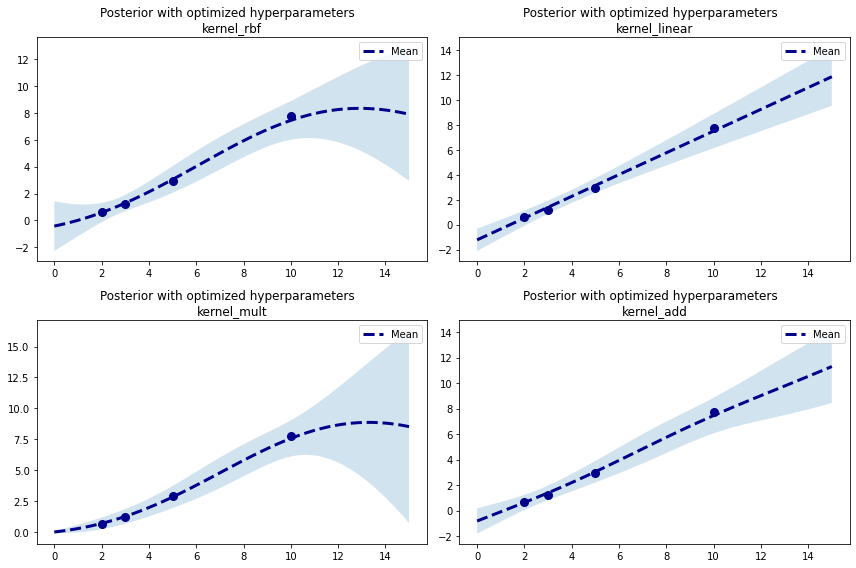

In [41]:
##### from scipy.optimize import minimize

def nll(X, f, kernel=kernel_rbf, noise=1e-2):
    """ Compute negative log marginal likelihood, naive implementation of Equation (2) or
    stable implementation using Cholesky decomposition
    
    Parameters:
    X : numpy array with N x 1 dimensions
        Training data input
    f : numpy array N x 1
        Training data output
    kernel : function (default: rbf kernel)
        Kernel function for which the parameters should be optimized
    noise : float
        Ensure that the matrix calculations work
        
    Returns:
    nll_naive 
    
    """
    
    f = f.ravel()

    def nll_naive(theta):
        params = {'var': theta[0],
                  'ell': theta[1],        
                  'var_b': theta[2],
                  'off': theta[3]}
        cov_y = kernel(X, X, params) + noise**2 * np.eye(N)
        return 0.5 * f.dot(np.linalg.inv(cov_y).dot(f)) + \
               0.5 * np.log(np.linalg.det(cov_y)) + \
               0.5 * N * np.log(2*np.pi)
    
    def nll_stable(theta):
        params = {'var': theta[0],
                  'ell': theta[1],        
                  'var_b': theta[2],
                  'off': theta[3]}
        cov_y = kernel(X, X, params)     # weniger noise wenn ich noise**2 nehm statt 1e-5
        L = np.linalg.cholesky(cov_y + 1e-5 * np.eye(N) )
        alpha_1 = np.linalg.solve(L, f)
        alpha = np.linalg.solve(L.T, alpha_1)
        
        return 0.5 * f.T.dot(alpha) + \
               np.sum(np.log(np.diagonal(L))) + \
               0.5 * N * np.log(2*np.pi)
    
    return nll_stable

    
plt.figure(figsize=(12, 8))

# Optimize parameters for all kernels: minimize nll 
for i, kernel in enumerate([kernel_rbf, kernel_linear, kernel_mult, kernel_add]):
    res = minimize(nll(X, f, kernel=kernel, noise=sigma_f), [1, 1, 1, 1],
                   bounds=((1e-2, None), (1e-2, None), (1e-2, None), (1e-2, None)),
                   method='L-BFGS-B')

    # compute posterior with optimized parameters
    var_opt, ell_opt, var_b_opt, off_opt = res.x
    params = {'var': var_opt,
              'ell': ell_opt,        
              'var_b': var_b_opt,
              'off': off_opt}

    mu_s, cov_s = posterior(X, X_s, f, kernel, params=params, noise=sigma_f)
    plt.subplot(2,2,(i+1))
    plot_gp(mu_s, cov_s, X_s, X, f)
    plt.title(f'Posterior with optimized hyperparameters  \n{kernel.__name__}')
plt.tight_layout()        
plt.show()



# Leave-one-out cross-validation (LOOCV)

To estimate the performance of the different models, we use k-fold cross-validation, where the training data is split into $k$ folds. In our case, $k=N$ is the most appropriate method, also called Leave-one-out cross-validation. Here, we train on all data cases except for $i$ in fold $i$, and then test on $i$. We leave one data point out from the training set and evaluate the prediction of the model for this data point. Each data point will be used as a test point, all other together as test set. By computing summary statistics, we get an overall evaluation of the model's performance. The reasons we use LOOCV is due to the small data size and the advantage of giving reliable and unbiased estimates of the model performance [2,7]. 

[8]: Compute test error on held out point and Average test errors!  
See https://robjhyndman.com/hyndsight/crossvalidation/

In [54]:
# Use LOOCV for specified model (kernel) and return all 4 predictions
def loocv(X, f, kernel=kernel_rbf, noise=1e-2):
    """ Leave-one-out cross-validation to compare model performances
    For each input data point, remove it from training data, then:
        Optimize hyperparameters of specified kernel 
        Derive posterior distribution with optimized parameters
        Obtain prediction for left-out data point
    
    Parameters:
    X : numpy array N x 1
        Training data input
    f : numpy array N x 1
        Training data output
    kernel : function (default: rbf kernel)
        Kernel function that specifies respective model
        
    Returns:
    predictions : list
        List of predictions of left-out training data points    
    """
    predictions = []
    N = len(X) - 1
    for leave_out in range(N+1):
        X_new = np.delete(X, leave_out).reshape(-1,1)
        f_new = np.delete(f, leave_out).reshape(-1,1)
        if len(noise)>1:
            noise_new = np.delete(noise, leave_out).reshape(-1,1)
        else:
            noise_new = noise

        res = minimize(nll(X_new, f_new, kernel=kernel, noise=noise_new), [1, 1, 1, 1],
                   bounds=((1e-2, None), (1e-2, None), (1e-2, None), (1e-2, None)),
                   method='L-BFGS-B')
        
        var_opt, ell_opt, var_b_opt, off_opt = res.x
        params = {'var': var_opt,
                  'ell': ell_opt,        
                  'var_b': var_b_opt,
                  'off': off_opt}
        mu_s, cov_s = posterior(X_new, X_s, f_new, kernel, params=params, noise=noise_new)
        
        # prediction for left out data point
        print(X_s[16])
        print(X_s[17])
        print(X[leave_out])
        print(X_s-X[leave_out])
        print(np.absolute(X_s-X[leave_out]))
        print(np.absolute(X_s-X[leave_out]).argmin())
        idx_pred = np.absolute(X_s-X[leave_out]).argmin()
        predictions.append(mu_s.item(idx_pred))

    return predictions
    
    
# compute LOOCV for all kernels
print(f'True parameters: {f.reshape(1,-1)}')
for i, kernel in enumerate([kernel_rbf, kernel_linear, kernel_mult, kernel_add]):
    # decrease N to account for smaller training set in LOOCV
    N = X.size-1    
    predictions = loocv(X=X, f=f, kernel=kernel, noise=sigma_f)
    print(f'\nPredictions for {kernel.__name__}: {predictions}')
    # L2 distance
    l2dist = np.linalg.norm(f.reshape(1,-1) - predictions)
    print(f'L2 Distance to true data point: {l2dist}')


    
        

True parameters: [[0.64 1.21 2.93 7.76]]
[4.89795918]
[5.20408163]
[2]
[[-2.        ]
 [-1.69387755]
 [-1.3877551 ]
 [-1.08163265]
 [-0.7755102 ]
 [-0.46938776]
 [-0.16326531]
 [ 0.14285714]
 [ 0.44897959]
 [ 0.75510204]
 [ 1.06122449]
 [ 1.36734694]
 [ 1.67346939]
 [ 1.97959184]
 [ 2.28571429]
 [ 2.59183673]
 [ 2.89795918]
 [ 3.20408163]
 [ 3.51020408]
 [ 3.81632653]
 [ 4.12244898]
 [ 4.42857143]
 [ 4.73469388]
 [ 5.04081633]
 [ 5.34693878]
 [ 5.65306122]
 [ 5.95918367]
 [ 6.26530612]
 [ 6.57142857]
 [ 6.87755102]
 [ 7.18367347]
 [ 7.48979592]
 [ 7.79591837]
 [ 8.10204082]
 [ 8.40816327]
 [ 8.71428571]
 [ 9.02040816]
 [ 9.32653061]
 [ 9.63265306]
 [ 9.93877551]
 [10.24489796]
 [10.55102041]
 [10.85714286]
 [11.16326531]
 [11.46938776]
 [11.7755102 ]
 [12.08163265]
 [12.3877551 ]
 [12.69387755]
 [13.        ]]
[[ 2.        ]
 [ 1.69387755]
 [ 1.3877551 ]
 [ 1.08163265]
 [ 0.7755102 ]
 [ 0.46938776]
 [ 0.16326531]
 [ 0.14285714]
 [ 0.44897959]
 [ 0.75510204]
 [ 1.06122449]
 [ 1.36734694

[4.89795918]
[5.20408163]
[2]
[[-2.        ]
 [-1.69387755]
 [-1.3877551 ]
 [-1.08163265]
 [-0.7755102 ]
 [-0.46938776]
 [-0.16326531]
 [ 0.14285714]
 [ 0.44897959]
 [ 0.75510204]
 [ 1.06122449]
 [ 1.36734694]
 [ 1.67346939]
 [ 1.97959184]
 [ 2.28571429]
 [ 2.59183673]
 [ 2.89795918]
 [ 3.20408163]
 [ 3.51020408]
 [ 3.81632653]
 [ 4.12244898]
 [ 4.42857143]
 [ 4.73469388]
 [ 5.04081633]
 [ 5.34693878]
 [ 5.65306122]
 [ 5.95918367]
 [ 6.26530612]
 [ 6.57142857]
 [ 6.87755102]
 [ 7.18367347]
 [ 7.48979592]
 [ 7.79591837]
 [ 8.10204082]
 [ 8.40816327]
 [ 8.71428571]
 [ 9.02040816]
 [ 9.32653061]
 [ 9.63265306]
 [ 9.93877551]
 [10.24489796]
 [10.55102041]
 [10.85714286]
 [11.16326531]
 [11.46938776]
 [11.7755102 ]
 [12.08163265]
 [12.3877551 ]
 [12.69387755]
 [13.        ]]
[[ 2.        ]
 [ 1.69387755]
 [ 1.3877551 ]
 [ 1.08163265]
 [ 0.7755102 ]
 [ 0.46938776]
 [ 0.16326531]
 [ 0.14285714]
 [ 0.44897959]
 [ 0.75510204]
 [ 1.06122449]
 [ 1.36734694]
 [ 1.67346939]
 [ 1.97959184]
 [ 2.2857

# AIC

## 2 Multiple dimensions

# Compare with scikit's Gaussian Process Implementation [6]

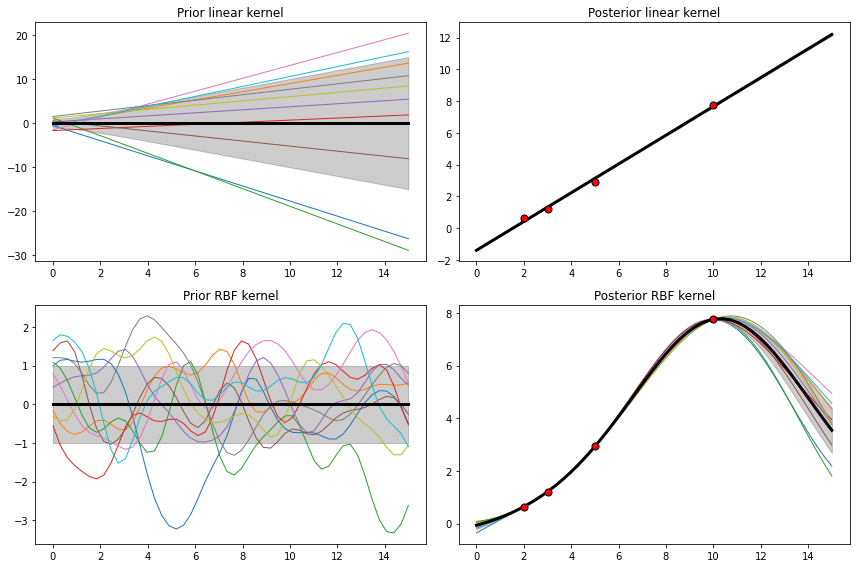

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, RBF


gpr_l = GaussianProcessRegressor(kernel=DotProduct())
gpr_r = GaussianProcessRegressor(kernel=RBF())

X_s_ = np.linspace(0, 15, N_s)
X_ = np.array([2,3,5,10]).reshape(-1,1)
f_ = np.array([0.64,1.21,2.93,7.76])

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
y_mean_l, y_std_l = gpr_l.predict(X_s_[:, np.newaxis], return_std=True)
plt.plot(X_s_, y_mean_l, 'k', lw=3, zorder=9)
plt.fill_between(X_s_, y_mean_l - y_std_l, y_mean_l + y_std_l,
                     alpha=0.2, color='k')
y_samples_l = gpr_l.sample_y(X_s_[:, np.newaxis], 10)
plt.plot(X_s_, y_samples_l, lw=1)
plt.title("Prior linear kernel")

gpr_l.fit(X_,f_)

y_mean_l, y_std_l = gpr_l.predict(X_s_[:, np.newaxis], return_std=True)
plt.subplot(2, 2, 2)
plt.plot(X_s_, y_mean_l, 'k', lw=3, zorder=9)
plt.fill_between(X_s_, y_mean_l - y_std_l, y_mean_l + y_std_l,
                     alpha=0.2, color='k')
y_samples_l = gpr_l.sample_y(X_s_[:, np.newaxis], 10)
plt.plot(X_s_, y_samples_l, lw=1)
plt.scatter(X_[:, 0], f_, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.tight_layout()
plt.title("Posterior linear kernel")


plt.subplot(2, 2, 3)
y_mean_r, y_std_r = gpr_r.predict(X_s_[:, np.newaxis], return_std=True)
plt.plot(X_s_, y_mean_r, 'k', lw=3, zorder=9)
plt.fill_between(X_s_, y_mean_r - y_std_r, y_mean_r + y_std_r,
                     alpha=0.2, color='k')
y_samples_r = gpr_r.sample_y(X_s_[:, np.newaxis], 10)
plt.plot(X_s_, y_samples_r, lw=1)
plt.title("Prior RBF kernel")

gpr_r.fit(X_,f_)

y_mean_r, y_std_r = gpr_r.predict(X_s_[:, np.newaxis], return_std=True)
plt.subplot(2, 2, 4)
plt.plot(X_s_, y_mean_r, 'k', lw=3, zorder=9)
plt.fill_between(X_s_, y_mean_r - y_std_r, y_mean_r + y_std_r,
                     alpha=0.2, color='k')
y_samples_r = gpr_r.sample_y(X_s_[:, np.newaxis], 10)
plt.plot(X_s_, y_samples_r, lw=1)
plt.scatter(X_[:, 0], f_, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.tight_layout()
plt.title("Posterior RBF kernel")



plt.show()

# References

[1] Jochen  Görtler,  Rebecca  Kehlbeck,  and  Oliver  Deussen.   A  visual  exploration  of gaussian processes. Distill, 4:e17, 2019.  
[2] Kevin P. Murphy. Machine Learning: a probabilistic perspective.  MIT press, 2012.   
[3] Rasmussen, Carl Edward. Gaussian processes in machine learning. In Summer school on machine learning, Springer, 2003.  
[4] https://www.cs.toronto.edu/~duvenaud/cookbook/  
[5] https://krasserm.github.io/2018/03/19/gaussian-processes/  
[6] https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html  
[7] https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/  
[8] https://web.stanford.edu/class/stats202/notes/Resampling/LOOCV.html  
[9] Kermack, W. O., & McKendrick, A. G. (1927). A contribution to the mathematical theory of epidemics. Proceedings of the royal society of london. Series A, Containing papers of a mathematical and physical character, 115(772), 700-721.  
[10] Češka, M., Pilař, P., Paoletti, N., Brim, L., & Kwiatkowska, M. (2016, April). PRISM-PSY: precise GPU-accelerated parameter synthesis for stochastic systems. In International Conference on Tools and Algorithms for the Construction and Analysis of Systems (pp. 367-384). Springer, Berlin, Heidelberg.